# MNIST digits dataset modelling

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()

In [2]:
print("X: ", digits.data.shape, "\nY: ", digits.target.shape)

X:  (1797, 64) 
Y:  (1797,)


SKLEARN does not have the whole MNIST dataset

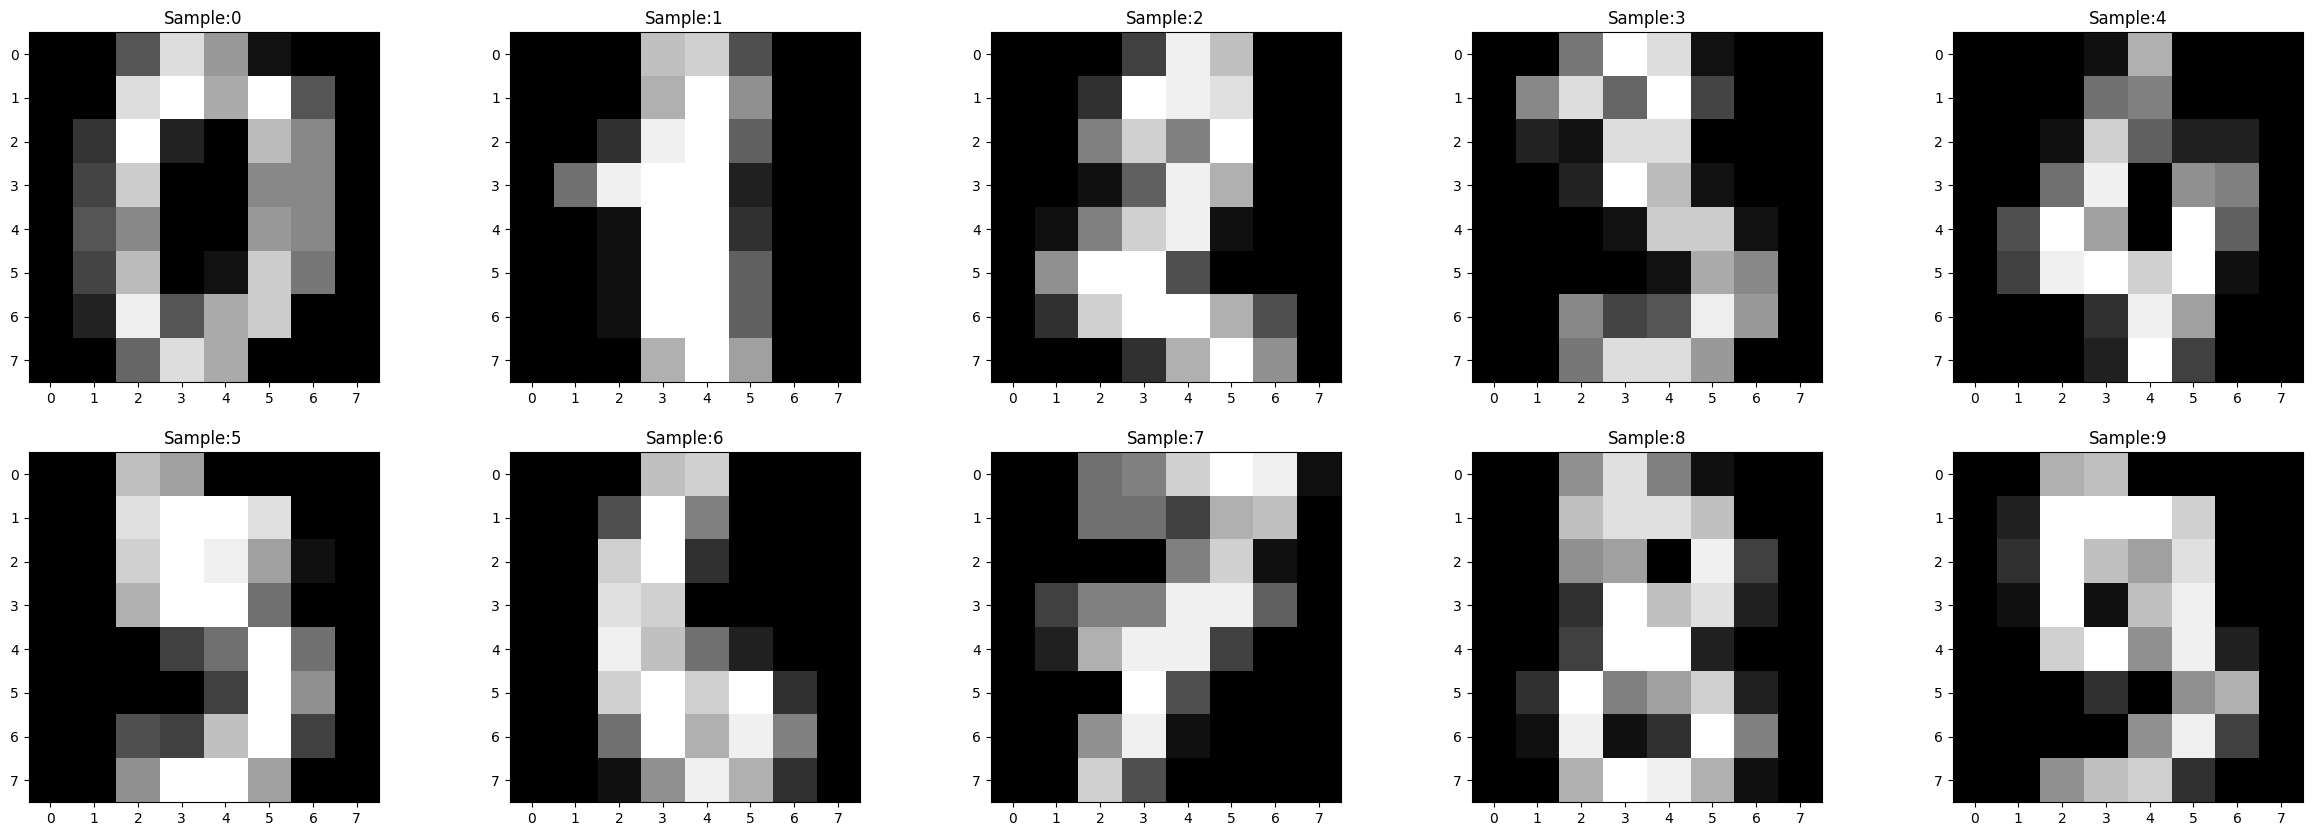

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 10))
for index, (image, label) in enumerate(zip(digits.data[:10], digits.target[:10])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title(f"Sample:{label}")

And the examples included are not in the original quality

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()

In [14]:
logistic_regression.fit(x_train, y_train)
predictions = logistic_regression.predict(x_test)

/Users/Bartek/Desktop/Bartek/Programowanie/Python/Portfolio/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
test_score = round(logistic_regression.score(x_test, y_test), 2)
print("Accuracy: ",test_score*100, "%")

Accuracy:  97.0 %


In [16]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predictions)


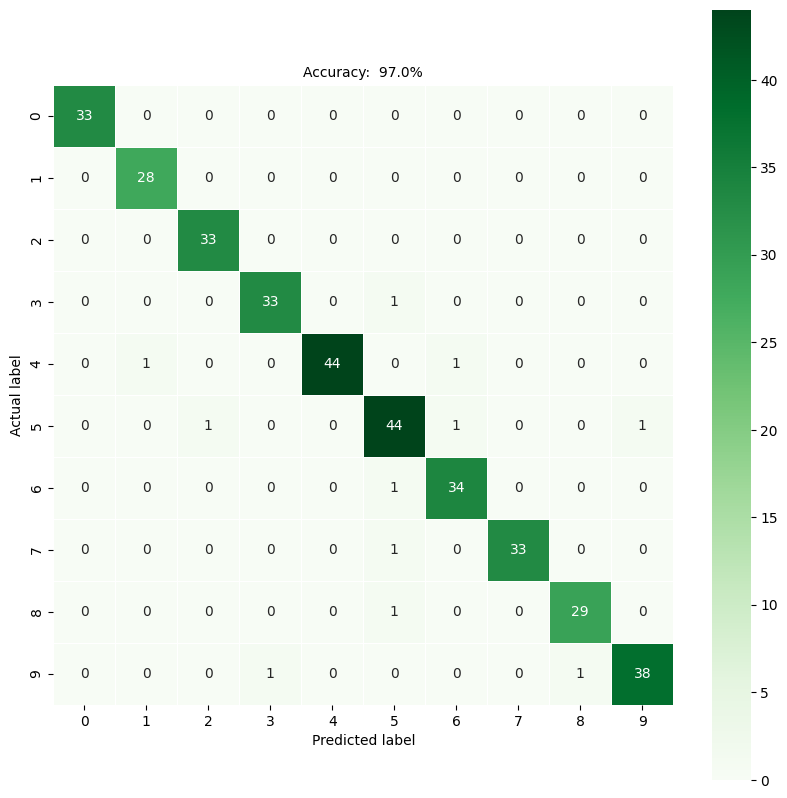

In [17]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Greens');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = f"Accuracy:  {test_score*100}%"
plt.title(all_sample_title, size = 10);

## This dataset is definitely not big enough to perform such modeling, therefore full MNIST dataset is required

In [18]:
from tensorflow_datasets.core.utils.lazy_imports_utils import tensorflow as tf
def extract_mnist_images(image_filepath, num_images):
  with tf.io.gfile.GFile(image_filepath, "rb") as f:
    f.read(16)  # header
    buffer = f.read(28 * 28 * num_images)
    data = np.frombuffer(
        buffer,
        dtype=np.uint8,
    ).reshape(num_images, 28, 28, 1)
    return data


def extract_mnist_labels(labels_filepath, num_labels):
  with tf.io.gfile.GFile(labels_filepath, "rb") as f:
    f.read(8)  # header
    buffer = f.read(num_labels)
    labels = np.frombuffer(buffer, dtype=np.uint8).astype(np.int64)
    return labels

In [19]:
mnist_train_images = extract_mnist_images("train-images-idx3-ubyte", 60000)
mnist_test_images = extract_mnist_images("t10k-images-idx3-ubyte", 10000)

mnist_train_labels = extract_mnist_labels("train-labels-idx1-ubyte", 60000)
mnist_test_labels = extract_mnist_labels("t10k-labels-idx1-ubyte", 10000)

In [20]:
print("\nTrain images shape:", mnist_train_images.shape, "\nTrain labels shape:", mnist_train_labels.shape, "\nTest images shape:", mnist_test_images.shape, "\nTest labels shape:", mnist_test_labels.shape)


Train images shape: (60000, 28, 28, 1) 
Train labels shape: (60000,) 
Test images shape: (10000, 28, 28, 1) 
Test labels shape: (10000,)
